### Integration of SVM and MVO 
3 factor, 3 turnover, premium of 10% experiments

This notebook only contains exact solves

In [2]:
import gurobipy as gp
import numpy as np
from gurobipy import GRB
pth = ''
import sys
import math
import time

from python.packages import *
from python.svm_mvo import *
from python.svm import *
from python.analysis_tools import *
from itertools import product
import os

%matplotlib inline
## Import Forecasts
forecasts = pd.read_pickle(pth +'cache/Forecasts.pkl')
## Import Returns
rets = pd.read_pickle(pth + 'cache/RETS.pkl')
## Import feature vectors
wrds_svm = pd.read_pickle(pth + 'cache/WRDS_ASOF.pkl')
## Import monthly prices
prices = pd.read_pickle(pth + 'cache/PRICES.pkl')

Set parameter Username
Academic license - for non-commercial use only - expires 2023-12-03


In [3]:
from numpy import linalg as la
import numpy as np


def nearestPD(A):
    """Find the nearest positive-definite matrix to input

    A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
    credits [2].

    [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

    [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
    """

    B = (A + A.T) / 2
    _, s, V = la.svd(B)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (B + H) / 2

    A3 = (A2 + A2.T) / 2

    if isPD(A3):
        return A3

    spacing = np.spacing(la.norm(A))
    # The above is different from [1]. It appears that MATLAB's `chol` Cholesky
    # decomposition will accept matrixes with exactly 0-eigenvalue, whereas
    # Numpy's will not. So where [1] uses `eps(mineig)` (where `eps` is Matlab
    # for `np.spacing`), we use the above definition. CAVEAT: our `spacing`
    # will be much larger than [1]'s `eps(mineig)`, since `mineig` is usually on
    # the order of 1e-16, and `eps(1e-16)` is on the order of 1e-34, whereas
    # `spacing` will, for Gaussian random matrixes of small dimension, be on
    # othe order of 1e-16. In practice, both ways converge, as the unit test
    # below suggests.
    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(la.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1

    return A3


def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = la.cholesky(B)
        return True
    except la.LinAlgError:
        return False

In [4]:
prev_mth = rets.index[0]
start_mth = prev_mth + pd.DateOffset(months=1)

In [5]:
#rank transform wrds
dfs = []
for name, df_group in wrds_svm.groupby(['MonthStart']):
    ranked_df = df_group.loc[:,'srcq':'Vol'].rank(axis = 0)/(len(df_group)+1)
    standardized_df = (ranked_df - ranked_df.mean(axis = 0))/ranked_df.std(axis = 0)
    standardized_df.drop(columns= ['DIFFYear', 'date', 'DIFFMonth', 'DIFFActualDays', 'DIFFExpectedDays', 'DIFFExpectedDaysCorr'], inplace = True)
    dfs.append(standardized_df)
wrds_standard = pd.concat(dfs, axis = 0, ignore_index= False)

In [6]:
#groupby then rank within groups
flattened_returns = rets.melt(ignore_index=False, var_name='tic').reset_index()
flattened_returns = flattened_returns.rename(columns ={'StartMonth': 'MonthStart'})
flattened_returns.index = pd.MultiIndex.from_frame(flattened_returns[['MonthStart', 'tic']])
flattened_returns.drop(columns = ['MonthStart', 'tic'], inplace=True)
dataset = pd.merge(flattened_returns, wrds_standard, left_index=True, right_index=True, how = 'inner')
dataset.sort_index(inplace=True)

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

ratio = 0.1 #% of assets

idx = pd.IndexSlice
X = dataset.loc[idx[prev_mth,:], ['Vol', 'ceqq']].values #['Vol', 'ceqq']].values #'srcq':'Vol'].values
y = dataset.loc[idx[prev_mth,:], 'value'].values
y = (y  >= np.percentile(y, 100*(1- ratio))).astype(int)
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)

#preprocessing
cov_, mean_ = forecasts[start_mth]
N = len(mean_)

cov = cov_[:N,:N] #+ 0.03*np.identity(N)
mean = mean_[:N,:]
tics = list(rets.columns[:N])

#get the wharton research data for the valid tickers for the month
#cols =  ['INV3', 'PRO6', 'INV1']
Y = wrds_standard.loc[(start_mth,), ['Vol', 'ceqq']] # Y matrix in formulation

dpi_setting = 150

In [8]:

ret_constr = -1 #no return constraint
soft_margin = 10 #preference for separation feasibility

name = "final"
card_desc = "Card07"

turnover_descs = ["0_75", "1", "1_25"]
turnovers = [0.75/6, 1.00/6, 1.25/6] #divide by 6!
AssetLim = math.floor(N*ratio)
epsilon = 0.1 #epsilon hyper-parameter
non_negativity_setting = True #set the hyperplane to have a normal in the non-negative orthant
ratios = [0.1, 0.3, 0.5, 0.7, 0.9]
            #SVM Heavy to not heavy
epsilons = [1e-2, 1e-3, 1e-4]
epsilons_desc = {1e-2:"eps negative 2", 1e-3:"eps negative 3", 1e-4:"eps negative 4"}
card_desc_list = {0.1:"Card01", 0.3:"Card03", 0.5:"Card05", 0.7:"Card07", 0.9:"Card09"}


In [9]:
class DualSVM:
    # This class models the support vector machine sub problem in the ADM method
    big_m = 100
    # noinspection PyTypeChecker
    def __init__(self, exogenous, soft_margin, previous_exogenous = None,
                 previous_alpha = None, previous_z = None, z=None, kernel = None, epsilon=1):

        self.exogenous = exogenous  # n by p matrix of features for the tickers
        self.previous_exogenous = previous_exogenous #data for previous period
        self.previous_alpha = previous_alpha #alpha for previous period
        self.previous_z = previous_z #previous labels
        self.soft_margin = soft_margin  # hyper parameter
        n, m = self.exogenous.shape

        self.model = gp.Model(env=e)
        self.kernel = kernel
        self.alpha = self.model.addMVar(n, lb=0, ub = self.soft_margin)
        self.z = z
        self.epsilon = epsilon

    @property
    def svm_objective(self):
        """
        dual svm objective
        $\boldsymbol{\alpha}^{\intercal} \boldsymbol{1}
        - (1/2) \boldsymbol{\alpha} Q \boldsymbol{\alpha}
        where Q_{ij} = u_i u_j Kernel(y_i, y_j)
        :return:
        """
        self.kernel.fit(self.exogenous)
        self.Q = self.kernel.transform(self.exogenous)
        self.u = 2*self.z - 1
        if len(self.u.shape) == 1:
            self.u = np.expand_dims(self.u, axis=1)
        U = self.u@self.u.T
        QU = np.multiply(self.Q, U)
        QU = nearestPD(QU)
        return self.epsilon*self.alpha.sum() - (1 / 2) * (self.alpha @ QU @ self.alpha)

    @property
    def svm_change(self):
        """

        :return:
        """
        n, m = self.exogenous.shape
        Q_ = self.kernel.transform(self.previous_exogenous)

        self.u_previous = 2*self.previous_z - 1
        if len(self.u_previous.shape) == 1:
            self.u_previous = np.expand_dims(self.u_previous, axis=1)
        if len(self.previous_alpha.shape) == 1:
            self.previous_alpha = np.expand_dims(self.previous_alpha, axis=1)
        if len(self.u.shape) == 1:
            self.u = np.expand_dims(self.u, axis=1)

        U = self.u_previous @ self.u.T
        QU = np.multiply(Q_, U)

        return (-1)*self.previous_alpha.T @ QU @ self.alpha

    def set_model(self, svm_constrs=None, delta=0):

        self.model.remove(self.model.getConstrs())
        # parameter definitions

        # objective function components
        if svm_constrs:
            for con in svm_constrs:
                self.model.addConstr(con, 'target')

        hyperplane_penalty = self.svm_objective
        if delta != 0:
            hyperplane_penalty = self.svm_objective + self.svm_change

        self.model.setObjective(hyperplane_penalty, GRB.MAXIMIZE)

        self.model.addConstr(self.u.T@self.alpha == 0)
        #update bounds here

    def optimize(self, cbb=None):
        n, m = self.exogenous.shape
        if cbb not in [None]:
            self.model._cur_obj = float('inf')
            self.model._time = time.time()
            self.model.optimize(callback=cbb)
        else:
            self.model.optimize()

        if self.previous_alpha is None:
            v = np.multiply(np.expand_dims(self.alpha.x, axis = 1), self.u)
            for i in range(n):
                if self.alpha[i].x < self.soft_margin:
                    dot_product = self.Q[i,:]@v
                    self.b = self.u[i][0] - dot_product

            self.decision_boundary = self.Q@v + self.b
        else:
            v = np.multiply(np.expand_dims(self.alpha.x, axis = 1), self.u)
            Q_ = self.kernel.transform(self.previous_exogenous)
            print(Q_.shape)
            self.u_previous = 2*self.previous_z - 1
            if len(self.u_previous.shape) == 1:
                self.u_previous = np.expand_dims(self.u_previous, axis=1)

            if len(self.previous_alpha.shape) == 1:
                self.previous_alpha = np.expand_dims(self.previous_alpha, axis = 1)

            v_previous = np.multiply(self.previous_alpha, self.u_previous)
            for i in range(n):
                if self.alpha[i].x < self.soft_margin:
                    v = np.multiply(np.expand_dims(self.alpha.x, axis = 1), self.u)
                    dot_product = self.Q[i,:]@v
                    dot_product_previous = Q_[:,i].T@v_previous
                    self.b = self.u[i][0] - dot_product - dot_product_previous
            self.decision_boundary = self.Q@v + Q_.T@v_previous + self.b

    def predict(self, X):
        self.kernel.fit(self.exogenous)
        Q = self.kernel.transform(X)
        if self.previous_alpha is None:
            v = np.multiply(np.expand_dims(self.alpha.x, axis = 1), self.u)
            return np.sign(Q@v + self.b)
        else:
            v = np.multiply(np.expand_dims(self.alpha.x, axis = 1), self.u)
            self.kernel.fit(self.previous_exogenous)
            Q_  = self.kernel.transform(X)

            self.u_previous = 2*self.previous_z - 1

            if len(self.u_previous.shape) == 1:
                self.u_previous = np.expand_dims(self.u_previous, axis=1)
            if len(self.previous_alpha.shape) == 1:
                    self.previous_alpha = np.expand_dims(self.previous_alpha, axis = 1)

            v_previous = np.multiply(self.previous_alpha, self.u_previous)
            # print("Q ", Q.shape)
            # print("Q_", Q_.shape)
            # print("v", v.shape)
            # print("v_prev", v_previous.shape)
            # print(self.b)
            return np.sign(Q@v + Q_@v_previous + self.b)

In [10]:

def compute_best_classifer(X, y):

    cv = StratifiedShuffleSplit(n_splits=4, test_size=0.2, random_state=42)
    C_range = np.logspace(-1, 5, 10, base = 5)
    gamma_range = np.logspace(-4, 1, 10, base=5)

    grid = train_svm(X, y, gamma_range, C_range, cv, plot=True)
    print(
        "The best parameters are %s with a score of %0.2f"
        % (grid.best_params_, grid.best_score_)
)
    gamma = grid.best_params_['sbf__gamma']
    C = grid.best_params_['svm__C']
    kernel = CustomRBFKernel(gamma = gamma)

    SVM_ = DualSVM(X ,C, kernel =kernel)
    SVM_.z = y
    SVM_.set_model()
    SVM_.optimize()

    plotSVC('Testing', X, y, SVM_)

    return SVM_.alpha.x, gamma

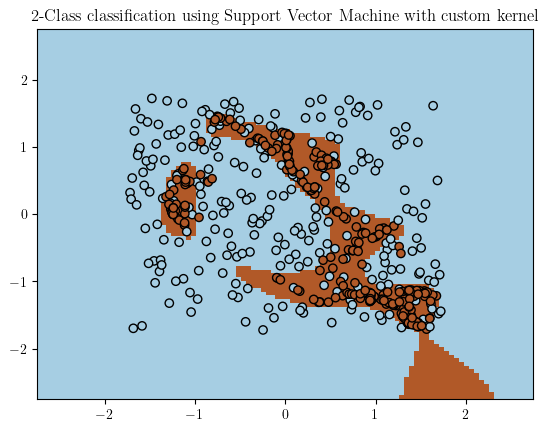

The best parameters are {'sbf__gamma': 0.836251030950374, 'svm__C': 3125.0, 'svm__kernel': 'precomputed'} with a score of 0.84
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads
Optimize a model with 1 rows, 514 columns and 514 nonzeros
Model fingerprint: 0x233113c3
Model has 132355 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e-08, 2e+00]
  Bounds range     [3e+03, 3e+03]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.02s
Presolved: 1 rows, 514 columns, 514 nonzeros
Presolved model has 132355 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 197
 AA' NZ     : 1.950e+04
 Factor NZ  : 1.970e+04 (roughly 1 MB of memory)
 Factor Ops : 2.607e+06 (less than 1 second per iteration)
 Threads    : 14

                  Objective                Residual
Iter       Primal          Dual 

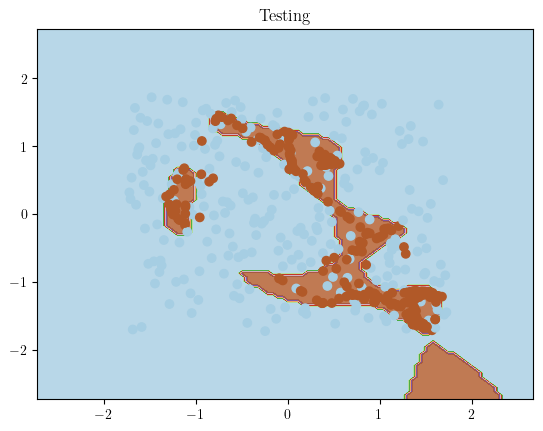

In [11]:
previous_alpha, gamma = compute_best_classifer(X, y)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads
Optimize a model with 290 rows, 1716 columns and 1716 nonzeros
Model fingerprint: 0x6bf93061
Model has 41041 quadratic objective terms
Variable types: 1430 continuous, 286 integer (286 binary)
Coefficient statistics:
  Matrix range     [2e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-07, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+01]
Found heuristic solution: objective 0.0094161
Presolve removed 2 rows and 1144 columns
Presolve time: 0.00s
Presolved: 288 rows, 572 columns, 1144 nonzeros
Presolved model has 41041 quadratic objective terms
Variable types: 286 continuous, 286 integer (286 binary)

Root relaxation: objective 6.471338e-04, 178 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    Be

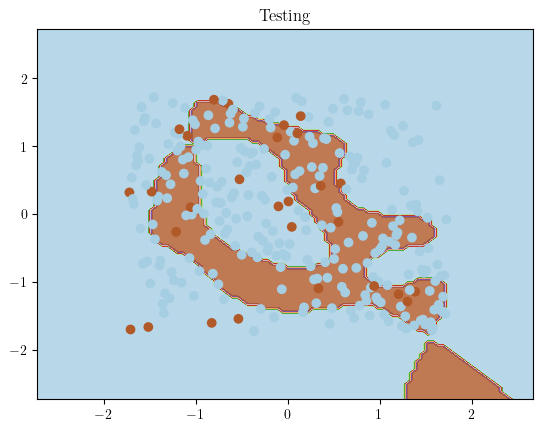

In [12]:
epsilon = 0.1
MVO_ = MVO(tics, mean, cov, ret_constr, AssetLim, epsilon=epsilon)
MVO_.set_model()
MVO_.optimize()
kernel = CustomRBFKernel(gamma = gamma)
SVM_ = DualSVM(Y.values ,5, kernel =kernel, epsilon = epsilon)
SVM_.z = MVO_.z.x
SVM_.previous_alpha = previous_alpha
SVM_.previous_exogenous = X
SVM_.previous_z = y
SVM_.set_model(svm_constrs=None, delta = 1)
SVM_.optimize()
plotSVC('Testing', Y.values, MVO_.z.x, SVM_)

In [15]:
MVO_.decision_boundary = SVM_.decision_boundary
MVO_.soft_margin = 5
MVO_.set_model()
MVO_.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads
Optimize a model with 576 rows, 1716 columns and 2288 nonzeros
Model fingerprint: 0x40361eca
Model has 41041 quadratic objective terms
Variable types: 1430 continuous, 286 integer (286 binary)
Coefficient statistics:
  Matrix range     [2e-04, 7e+01]
  Objective range  [2e-02, 2e-02]
  QObjective range [2e-07, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-03, 4e+01]

MIP start from previous solve produced solution with objective 4.3847 (0.02s)
Loaded MIP start from previous solve with objective 4.3847

Presolve removed 288 rows and 1144 columns
Presolve time: 0.00s
Presolved: 288 rows, 572 columns, 1144 nonzeros
Presolved model has 41041 quadratic objective terms
Variable types: 286 continuous, 286 integer (286 binary)

Root relaxation: objective 1.343064e+00, 404 iterations, 0.02 seconds (0.03 work units)

    Nodes    |    Current Nod

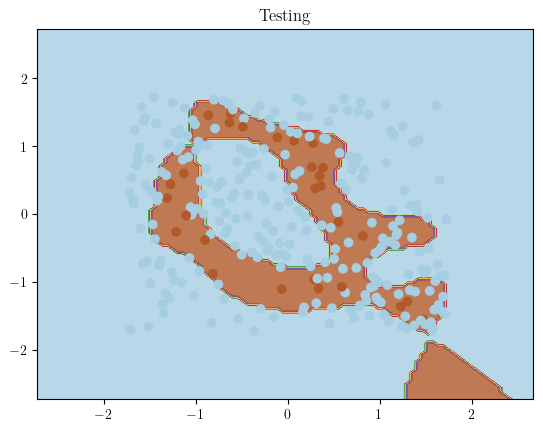

In [16]:
plotSVC('Testing', Y.values, MVO_.z.x, SVM_)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads
Optimize a model with 1 rows, 286 columns and 286 nonzeros
Model fingerprint: 0xb015ee5d
Model has 41041 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+01]
  QObjective range [2e-08, 2e+00]
  Bounds range     [5e+00, 5e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.00s
Presolved: 1 rows, 286 columns, 286 nonzeros
Presolved model has 41041 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 177
 AA' NZ     : 1.575e+04
 Factor NZ  : 1.593e+04
 Factor Ops : 1.896e+06 (less than 1 second per iteration)
 Threads    : 14

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   4.92219539e+09  3.64776825e+05  8.06e+04 2.26e+04  1.00e+06     0s
   1   5.74217656e+07  3.89799781e+04 

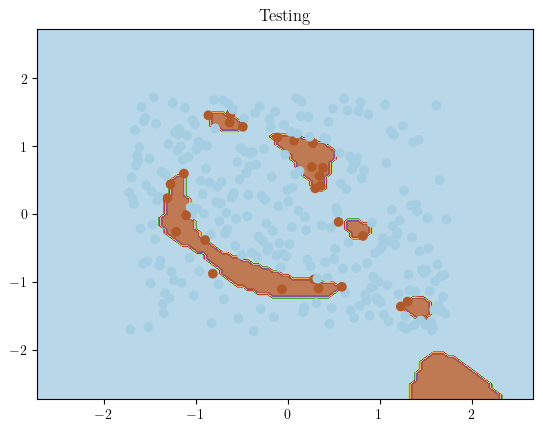

In [17]:
SVM_.z = MVO_.z.x
SVM_.previous_alpha = previous_alpha
SVM_.previous_exogenous = X
SVM_.previous_z = y
SVM_.set_model(svm_constrs=None, delta = 1)
SVM_.optimize()
plotSVC('Testing', Y.values, MVO_.z.x, SVM_)